# 传统图像处理模块

| 更新时间 | 负责人 | 内容 | 备注 |
| --- | --- | --- | --- |
| 2022年4月13日 | Ray | 初次编写文档 | --- |
| 2022年4月24日 | Coty | 添加AprilTag识别、三维坐标系以及红蓝小球追踪 | --- |
| 2022年4月25日 | Coty | 添加AprilTag多个三维坐标显示，二维码和条形码的定位、读取信息 | --- |
| 2022年4月28日 | Dls | 修订排版，以下功能仅在 0.4.7 以上版本支持 | --- |

## [MaixPy3 视觉模块开发记录 2022年05月24日更新](https://wiki.sipeed.com/soft/maixpy3/zh/develop/opmv_cv.html)

主要分为以下几大块：

- 图像统计模块（获取图像信息）

- 颜色追踪模块（追踪颜色信息）

- 标记追踪模块（条码定位测距）

- 图像滤波模块（传统图像处理）

- 特征检测模块（特征提取追踪）


## 颜色统计模块

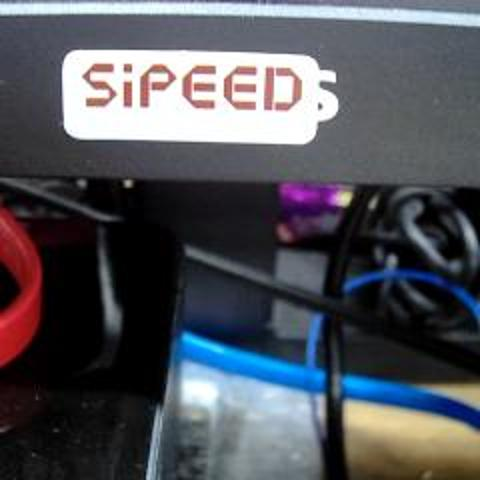

[82, 98, 98, 19, 46, 98, 61, 98, 10, -1, -1, 15, -3, 44, -1, 20, 5, -1, -1, 9, -6, 31, -1, 13]


Traceback (most recent call last):
  File "<string>", line unknown, in <module>
Remote.KeyboardInterrupt


In [1]:
from maix import image,display,camera
ROI=(80,30,15,15)
while True:
    img = camera.capture()
    tmp = img.get_statistics(roi=ROI)
    display.show(img)

    print("l Mean Median Mode STDev Min Max LQ UQ", tmp[0:8])
    print("a Mean Median Mode STDev Min Max LQ UQ", tmp[8:16])
    print("b Mean Median Mode STDev Min Max LQ UQ", tmp[16:24])

    # example data

    # openmv
    # "l_mean":42, "l_median":38, "l_mode":3, "l_stdev":27, "l_min":0, "l_max":100, "l_lq":19, "l_uq":65,
    # "a_mean":3, "a_median":1, "a_mode":0, "a_stdev":22, "a_min":-59, "a_max":81, "a_lq":-7, "a_uq":18,
    # "b_mean":5, "b_median":2, "b_mode":2, "b_stdev":27, "b_min":-88, "b_max":76, "b_lq":-12, "b_uq":25

    # maixpy3
    # 42, 37, 3, 27, 0, 98, 18, 66,
    # 2, -1, -1, 22, -72, 83, -8, 15,
    # 7, 1, -1, 26, -73, 76, -11, 25



## 颜色追踪模块

以红蓝小球追踪为例，还有待整理（20220428）。

In [ ]:
#!/usr/bin/python3

from maix import image, display, camera, gpio
import serial,time


ser = serial.Serial("/dev/ttyS1",115200,timeout=0.2)    # 连接串口

tmp = ser.readline()
print('serial test start ...') 

ser.write(b" \r\n")
time.sleep(1)
ser.write(b"{V831:Ready!}\n")

set_LAB = [[(10, 35, -37, 70, 73, 62)],     #red
           [(10, 5, -87, 79, 62, -28)]]     #blue
#LAB阈值的初始化格式:[L_MIN,A_MIN,B_MIN,L_MAX,A_MAX,B_MAX]

flag = '1'
now_time = time.time()

ser.write(b"ok\n")

while True:
    img = camera.capture()
    for j in range(2):
        blobs = img.find_blobs(set_LAB[j])    #在图片中查找lab阈值内的颜色色块
        if blobs :
            for i in blobs:
                size = i["w"] * i["h"]#最大是240 *240也就是57600
                if size > 2000 : 
                    x_start = i["x"]
                    x_end = i["x"] + i["w"]
                    x_center = int((x_start + x_end) / 2)    #中心坐标
                    y_start = i["y"]
                    y_end = i["y"] + i["h"]
                    y_center = int((y_start + y_end) / 2)
                    m = max((x_center - i["w"]*0.3) ,0)
                    n = max((y_center - i["h"]*0.3) ,0)
                    m = min((x_center - i["w"]*0.3) ,240)
                    n = min((y_center - i["h"]*0.3) ,240)
                    mk = [int(m),int(n), 20, 20]

                    git_color = img.get_blob_color(mk, 0, 0)
                    img.draw_rectangle(9, 9, 21, 21, color=(255, 255, 255), thickness=1) #左上角颜色区域画出来
                    color = (int(git_color[0]), int(git_color[1]), int(git_color[2]))
                    img.draw_rectangle(10, 10, 20, 20, color, thickness=-1) #将颜色填充到左上角
                    img.draw_circle(x_center, y_center, int(i["h"]/2 + 8), color, thickness=3)   #画一个中心点在（50,50），半径为20的空心 圆
                    if(j == 0):
                        string = 'Red'
                    elif j == 1 :
                        string = 'Blue'
                    str_size = image.get_string_size(string)
                    img.draw_string(x_center - int(str_size[0]/2) - 5, y_start - 35, string, scale = 1.5,color = (int(git_color[0]), int(git_color[1]), int(git_color[2])), thickness = 2)
                    if flag == '1' :
                        flag = '0'
                        now_time = time.time() #time.asctime()
                    
    display.show(img)
    time_t = time.time() - now_time
    if(time_t > 0.03) :
        if flag == '0':
            tep = "{V831:Space_x->" + str(x_center-120) + "}"   #先获得数据
            ser.write(tep.encode("utf-8"))                      #变成串口能发送的格式发出去
            flag = 'x'                                          #先发X再发Y，需要等等不然32会反映不过来，但又不能阻塞
            
        elif flag == 'x' :
            flag = '1'
            tep = "{V831:Space_y->" + str(y_center-120) + "}"   #先获得数据
            ser.write(tep.encode("utf-8"))                      #变成串口能发送的格式发出去

        

**此代码配合其他MCU运行效果演示如图所示:**
 
![演示1](../asserts/findball.gif)

从演示图可以看出，MaixII-Dock 成功获得了小球距离中心点的偏差，通过串口发送数据给 MCU ，通过 PID 控制舵机带动摄像头转动，使得小球重新回归中心点位。

```python
set_LAB = [[(10, 35, -37, 70, 73, 62)],    #red
            [(10, 5, -87, 79, 62, -28)]]     #blue
```
对于LAB阈值的设置需要注意的是初始化的格式，**格式为:[L_MIN , A_MIN , B_MIN , L_MAX , A_MAX , B_MAX]**，此处初始化了红色和蓝色的LAB阈值。

```python
blobs = img.find_blobs(set_LAB[j])   
```

find_blobs() 函数目的是寻找对应的色块。

将目标区域的信息获取之后使用 **img.draw_circle()** 函数将目标圈住，最后将球距离中心点的偏差值( x 和 y 的偏差值)发送至 MCU，由 MCU 进行后续的计算。


## 标记追踪模块

### AprilTag 标记追踪测距


In [ ]:
#!/usr/bin/python3
from maix import display, camera 

f_x = (6 / 5.76) * 240 # 镜头的焦距是6MM，感光cmos的长是5.76mm，240像素是屏幕的长
f_y = (6 / 3.24) * 240 # 镜头的焦距是6MM，感光cmos的宽是3.24mm，240像素是屏幕的宽

c_x = 240 * 0.5  # 屏幕分辨率的一半
c_y = 240 * 0.5  # 屏幕分辨率的一半

while True:
    t = camera.capture()
    mks = t.find_apriltags(families = 16,fx = f_x,fy = f_y,cx = c_x,cy = c_y)
    for mk in mks:
      x_tran = mk['x_translation']
      y_tran = mk['y_translation']
      z_tran = mk['z_translation']
      #家族信息
      fam = mk['family']
      #外框数据
      x, y, w, h, id  =  mk['x'], mk['y'], mk['w'], mk['h'], mk['id']
      #内框数据
      x1,y1 = mk['corners'][0]   #访问字典的列表
      x2,y2 = mk['corners'][1]
      x3,y3 = mk['corners'][2]
      x4,y4 = mk['corners'][3]
      z1,z2 = mk['centroid']
      #虚拟距离
      length = (x_tran*x_tran + y_tran*y_tran + z_tran*z_tran)**0.5

      #画外框
      t.draw_rectangle(x, y, x + w, y + h, color=(0, 0, 255), thickness = 2) 
      #打印ID
      t.draw_string(int(x + w*0.15) , int(y + h*0.15) , str(id), scale = 4.0, color = (255, 0, 0), thickness = 3)  
      #画内框
      t.draw_line(x1, y1, x2, y2, color = (0, 255, 0), thickness = 3)  
      t.draw_line(x2, y2, x3, y3, color = (0, 255, 0), thickness = 3)  
      t.draw_line(x3, y3, x4, y4, color = (0, 255, 0), thickness = 3)  
      t.draw_line(x4, y4, x1, y1, color = (0, 255, 0), thickness = 3)  
      
      if(fam == 16):
        t.draw_string(x, y-20, "TAG36H11", scale = 1.0, color = (255, 0, 0), thickness = 2)
      
      t.draw_string(x, y+h+15, str(int(length * 3.0649 - 2))+" cm", scale = 1.0, color = (255, 0, 0), thickness = 2)  

    display.show(t)

**此代码运行效果演示如图所示：**

![演示1](../asserts/findtag1.gif)![演示2](../asserts/findtag2.gif)

在**_演示1_**中可以看到 MaixII-Dock 能够清楚地跟踪标签四个点的坐标并且显示出来(绿色框)，以及能够跟踪标签的最大框的坐标(蓝色框)，其实用户想要获取这些信息并不难。

如果想要获取标签四个点的坐标只需要获取字典中键值为 corners 的列表中的值即可，而想获得外框(蓝色框)的坐标只需要获取字典中键值为 x , y , w , h 的的值，最后像代码中所操作的一样即可。

字典的键值如下所示：
'x' , 'y' , 'w' , 'h' , 'id' , 'family' , 'centroid' , 'corners' , 'x_translation' , 'y_translation' , 'z_translation' , 'decision_margin' , 'hamming' , 'goodness' , 'x_rotation' , 'y_rotation' , 'z_rotation'。

在此仅介绍简单几个键值的含义。'x' , 'y' , 'w' , 'h' 键值返回的值分别是外框左上角 x 坐标和 y 坐标以及外框的长和宽。**特别注意的是键值 'corners' 返回的是一个列表，列表中的值代表着内框的四个顶点的坐标。**

在**_演示2_**中可以看到两个标签距离摄像头大概是22cm左右，**那么究竟是如何测出这个距离的呢？**请接着往下看：

**对于测距算法，需要知道的是：**

fx，以像素为单位的相机 X 焦距；

fy，以像素为单位的相机 Y 焦距；

cx，图像中心image.width()/2；

cy，图像中心image.height()/2；

具体 fx , fy , cx , cy 的计算在上诉代码注释区。

- **测距算法使用流程：**首先将 fx ，fy ，cx ，cy 传入 find_apriltags() 函数内部，读取返回的 x_translation ，y_translation ，z_translation 参数。由length = (x_tran*x_tran + y_tran*y_tran + z_tran*z_tran)**0.5 可以算出虚拟距离，这个虚拟距离 length 乘上一个比例系数 K 才是最终物体离 CMOS 的最终距离。

- **比例系数 K 的计算：**假设我们现在将一个物体放置在离 CMOS 距离 20cm 的地方，然后直接打印出 length 计算的结果，此时的 length 假设是 6.525 ，那么 K = 20 / 6.525 = 3.065。这时我们将 length 乘上这个比例系数 K 得出的结果就是真实的距离。**也就是说在第一次使用的时候需要确定比例系数 K ,在确定了 K 的大小过后，以后的使用就直接使用计算出来的比例系数 K 乘上计算出来的虚拟距离 length ，就是最后真实的距离。**（需要注意的是：最后算出的真实距离并不是标签距离摄像头的距离，而是标签距离CMOS的距离。**以MaixII-Dock为例，标配的摄像头镜头距离CMOS的距离大概是2cm，那么需要将最后算出的距离再减去2cm最后得出的结果才是标签距离摄像头的距离。**）




### AprilTag 获取角度信息以及三维坐标的显示


In [ ]:
#!/usr/bin/python3
from maix import display, camera 
import math

f_x = (6 / 5.76) * 240 # 镜头的焦距是6MM，感光cmos的长是5.76mm，240像素是屏幕的长
f_y = (6 / 3.24) * 240 # 镜头的焦距是6MM，感光cmos的宽是3.24mm，240像素是屏幕的宽

c_x = 240 * 0.5 # 屏幕分辨率的一半
c_y = 240 * 0.5 # 屏幕分辨率的一半

while True:
    t = camera.capture()
    mks = t.find_apriltags(families = 16,fx = f_x,fy = f_y,cx = c_x,cy = c_y)
    for mk in mks:

      #内框数据
      x1,y1 = mk['corners'][0]   #访问字典的列表
      x2,y2 = mk['corners'][1]
      x3,y3 = mk['corners'][2]
      x4,y4 = mk['corners'][3]
      
      #获取角度信息
      x_rol = mk['x_rotation']
      y_rol = mk['y_rotation']
      z_rol = mk['z_rotation']
      #画内框
      t.draw_line(x1, y1, x2, y2, color = (0, 255, 0), thickness = 3)  
      t.draw_line(x2, y2, x3, y3, color = (0, 255, 0), thickness = 3)  
      t.draw_line(x3, y3, x4, y4, color = (0, 255, 0), thickness = 3)  
      t.draw_line(x4, y4, x1, y1, color = (0, 255, 0), thickness = 3)  
    
      #显示当前角度
      t.draw_string(2, 2, "X rotation is: "+str(int(180*x_rol/3.14))+" Angle", scale = 1.0, color = (0, 0, 255), thickness = 1)    #90° ~ 270°  正对着是180°。上下
      t.draw_string(2, 15, "Y rotation is: "+str(int(180*y_rol/3.14))+" Angle", scale = 1.0, color = (0, 0, 255), thickness = 1)   #0° ~ 90°，270° ~ 360°   正对着是0°。 左右
      t.draw_string(2, 30, "Z rotation is: "+str(int(180*z_rol/3.14))+" Angle", scale = 1.0, color = (0, 0, 255), thickness = 1)   #0° ~ 360°   正对着是0°。 顺时针旋转增加    

      #右下角画框
      t.draw_string(140, 120, "Space", scale = 1.0, color = (125, 0, 0), thickness = 2)  
      t.draw_rectangle(140, 140, 235, 235, color=(128, 128, 128), thickness=2) 
      
      #画出三维坐标系
      t.draw_line(180, 200, int(180 - 40 * math.sin(z_rol)), int(240 - 40 * math.cos(z_rol) + 40 * math.cos(x_rol)), color = (255, 0, 0), thickness = 3)   
      t.draw_line(180, 200, int(140 + 40 * math.cos(z_rol) + 40 * math.cos(y_rol)), int(200 - 40 * math.sin(z_rol)), color = (0, 255, 0), thickness = 3) 
      t.draw_line(180, 200, int(180 + 40 * math.sin(y_rol)),int(200 - 40 * math.sin(x_rol)), color = (0, 0, 255), thickness = 3) 

    display.show(t)

**此代码运行效果演示如图所示：**

![三维坐标](../asserts/rotation.gif) 

可以看出在显示屏左上角打印出了标签的当前角度信息，那么如何获取这些信息呢？

- 如果想要获取标签的角度信息只需要获取字典中键值分别是 x_rotation，y_rotation，z_rotation  的的值即可，**需要指出的是获取的值是弧度，需要转换成角度的话需要使用弧度转角度公式**。将获取的弧度其乘上 180 再除以 3.14 即可（3.14选取了圆周率小数点后两位）。

- x_rotation 转为角度后取值范围是 **[90°,270°]** 正对着标签时显示为 **180°** ，在标签前后移动时变化。 y_rotation 转为角度后取值范围是 **[0°,90°]U[270°，360°]** 正对着标签时显示为 **0°** ，在标签左右移动时变化。z_rotation 转为角度后取值范围是 **[0°,360°]** 正对着标签时显示为 **0°** ,在标签旋转时变化。

**三维坐标系显示**

 三维坐标系生成代码如上代码中所示，将每一个轴的变化线性叠加即可获得一个不太准确的三维坐标系。

- 前后的变化会导致 x_rotation 的变化。当 x_rotation 变化时，X 轴 y 的长度应该为 40 \* cos(x_rol) ，但是 x_rotation 转换为角度的范围是 [90°,270°] 且正对标签时为 180°，画出 cos 图发现在定义域内 180° 点为极小值点，且整个取值区域内 cos 值都为负，我们不希望得到这样的图像。解决方法是将 cos 向上平移 40 ，使得 180° 点cos值为 0 ，而 90° 和 270° 为区间的最高点，是一个正数。此时终点 y 的结果为 **200 + 40 + 40 \* cos(x_rol)**，即转至 90° 或 270° 时，X 轴的长度为 200，与开始点重合，实际长度为 0 。而对于 Z 轴的长度处理思路相似，但是 Z 轴的投影使用的是 sin 函数，在 [90°,270°] 这个区间 90° 是极大值点且此时 sin 值为正数，270° 是极小值点且此时 sin 值为负数，正好符合实际需求，故不作处理。最后 Z 轴终点 y 的结果为**200 - 40 \* sin(x_rol)**。
 
- 左右的变化会导致 y_rotation 的变化。当 y_rotation 变化时，Y 轴 x 的长度应该为 40 \* cos(y_rol)，但是 y_rotation 转换为角度的范围是 [0°,90°]U[270°，360°]，且正对标签时为 0°，画出cos图发现图像被分割为了两个部分，但是不影响使用，因为在角度 [270°，360°] 内会随着倾角的增大而逐渐减小，所以最后终点 x 的结果是 **180 + 40 \* cos(y_rol)**。而对于 Z 轴的长度处理思路相似，此处不做过多解释，最终 Z 轴终点 x 的结果为**180 + 40 \* sin(y_rol)**。
 
- 旋转的变化会导致 z_rotation 的变化。当 z_rotation 变化时，X 轴 x 的长度应该为 40 \* sin(z_rol)，但此时由于 z_rotation 转换而来的角度会随着逆时针的转动而增大，所以 X 轴 x 的长度应该乘以 **-1** ，这样才能符合实际变化，最后终点 x 的结果为**180 - 40 \* sin(z_rol)**。X 轴 y 的长度为 40 \* cos(z_rol)，但是屏幕从上而下的像素点的值是逐渐增大的，所以虽然 cos 值在区间内部的变化是符合我们的预期，但是依旧要乘以 **-1**，最后终点 y 结果为 **200 - 40 \* cos(z_rol)**。对于 Y 轴的 x 和 y 的长度处理思路与上诉一样，但对于 x 的长度需要减去一个 40 抵消掉初始增量，最后终点结果分别为 **180 - 40 + 40 \* cos(z_rol)** 和 **200 - 40 \* sin(z_rol)**。

**最后将所有计算式线性叠加即可获得最终三维坐标系。由于算式是基于正对着标签码进行计算的，所以对于非正拿标签的情况，坐标系会出现混乱**
 

### AprilTag多个三维坐标的显示


In [ ]:
from maix import display, camera 
import math

f_x = (6 / 5.76) * 240 
f_y = (6 / 3.24) * 240 

c_x = 240 * 0.5 
c_y = 240 * 0.5 

while True:
    t = camera.capture()
    mks = t.find_apriltags(families = 16,fx = f_x,fy = f_y,cx = c_x,cy = c_y)
    for mk in mks:

      #内框数据
      x1,y1 = mk['corners'][0]   #访问字典的列表
      x2,y2 = mk['corners'][1]
      x3,y3 = mk['corners'][2]
      x4,y4 = mk['corners'][3]
      
      x_rol = mk['x_rotation']
      y_rol = mk['y_rotation']
      z_rol = mk['z_rotation']
      #画内框
      t.draw_line(x1, y1, x2, y2, color = (0, 255, 0), thickness = 3)  
      t.draw_line(x2, y2, x3, y3, color = (0, 255, 0), thickness = 3)  
      t.draw_line(x3, y3, x4, y4, color = (0, 255, 0), thickness = 3)  
      t.draw_line(x4, y4, x1, y1, color = (0, 255, 0), thickness = 3)  
    
      
      t.draw_string(x4, y4, "xR: "+str(int(180*x_rol/3.14)), scale = 1.0, color = (255, 0, 0), thickness = 2)    #90° ~ 270°  正对着是180°。上下
      t.draw_string(x4, y4 + 15, "yR: "+str(int(180*y_rol/3.14)), scale = 1.0, color = (255, 0, 0), thickness = 2)   #0° ~ 90°，270° ~ 360°   正对着是0°。 左右
      t.draw_string(x4, y4 + 30, "zR: "+str(int(180*z_rol/3.14)), scale = 1.0, color = (255, 0, 0), thickness = 2)   #0° ~ 360°   正对着是0°。 顺时针旋转增加
      
      t.draw_line(x4, y4, int(x4 - 40 * math.sin(z_rol)), int(y4 + 40 - 40 * math.cos(z_rol) + 40 * math.cos(x_rol)), color = (255, 0, 0), thickness = 3)   
      t.draw_line(x4, y4, int(x4 - 40 + 40 * math.cos(z_rol) + 40 * math.cos(y_rol)), int(y4 - 40 * math.sin(z_rol)), color = (0, 0, 0), thickness = 3) 
      t.draw_line(x4, y4, int(x4  + 40 * math.sin(y_rol)),int(y4 - 40 * math.sin(x_rol)), color = (0, 0, 255), thickness = 3) 
    display.show(t)

**此代码运行效果演示如图所示:**
 
![演示1](../asserts/rotation_more.gif)

在演示图中可以看到在每个标签上都打印出了一个三维坐标系，并且能够很好显示当前标签的角度信息。只需要将三维坐标系的原点定义在标签的左下角，且将三维坐标画线函数放置在for循环内部，即可出现如上图所示效果。


### 定位二维码及识别结果


In [ ]:
#!/usr/bin/python3
from maix import display, camera 

while True:
    t = camera.capture()
    mks = t.find_qrcodes()
    for mk in mks:
      #外框数据
      X = mk['x']
      Y = mk['y']
      W = mk['w']
      H = mk['h']
      
      #二维码信息
      string = mk['payload']

      #内框数据
      x1,y1 = mk['corners'][0]   #访问字典的列表
      x2,y2 = mk['corners'][1]
      x3,y3 = mk['corners'][2]
      x4,y4 = mk['corners'][3]
      
      #画外框
      t.draw_rectangle(X, Y, X + W, Y + H, color=(0, 0, 255), thickness = 2) 
      #打印信息
      t.draw_string(int(X) , int(Y - 35) , str(string), scale = 2.0, color = (255, 0, 0), thickness = 2)  #内框ID
      #画内框
      t.draw_line(x1, y1, x2, y2, color = (0, 255, 0), thickness = 3)  
      t.draw_line(x2, y2, x3, y3, color = (0, 255, 0), thickness = 3)  
      t.draw_line(x3, y3, x4, y4, color = (0, 255, 0), thickness = 3)  
      t.draw_line(x4, y4, x1, y1, color = (0, 255, 0), thickness = 3)  

    display.show(t)
    

**此代码运行效果演示如图所示：**

![演示1](../asserts/qrcode.gif)

在演示中可以看到 MaixII-Dock 能够清楚地跟踪并且框住二维码，将二维码信息打印到屏幕上。那么如何获取二维码坐标值以及信息呢？其实非常简单。

- 获取外框坐标：读取 **find_qrcodes()** 函数返回的字典中键值为: **x , y , w , h** 的值作为二维码外框的坐标信息(蓝色框)。
- 获取内框坐标：读取 **find_qrcodes()** 函数返回的字典中键值为: **corners** 的列表中的值作为二维码内框的坐标(绿色框)。
- 获取二维码信息：读取 **find_qrcodes()** 函数返回的字典中键值为: **payload** 的值作为二维码信息。

字典的键值如下所示：'x' , 'y' , 'w' , 'h' , 'payload' , 'version' , 'ecc_level' , 'mask' , 'data_type' , 'eci' , 'corners'。

在此仅介绍简单几个键值的含义。'x' , 'y' , 'w' , 'h' 键值返回的值分别是外框左上角 x 坐标和 y 坐标以及外框的长和宽。**而键值 'payload' 返回的值是二维码的信息，例如在二维码生成网站上输入 "Sipeed" 生成二维码，此时这个二维码的 'payload' 就是 "Sipeed"。**


### 定位条形码及识别结果


In [ ]:
#!/usr/bin/python3
from maix import display, camera 

while True:
    t = camera.capture()
    mks = t.find_barcodes()
    for mk in mks:
      
      #二维码信息
      string = mk['payload']
      TYPE = mk['type']
      
      #内框数据
      x1,y1 = mk['corners'][0]   #访问字典的列表
      x2,y2 = mk['corners'][1]
      x3,y3 = mk['corners'][2]
      x4,y4 = mk['corners'][3]

      #画内框
      t.draw_line(x1, y1, x2, y2, color = (0, 255, 0), thickness = 3)  
      t.draw_line(x2, y2, x3, y3, color = (0, 255, 0), thickness = 3)  
      t.draw_line(x3, y3, x4, y4, color = (0, 255, 0), thickness = 3)  
      t.draw_line(x4, y4, x1, y1, color = (0, 255, 0), thickness = 3)  
      
      #打印信息
      t.draw_string(int(x1) , int(y1 - 35) , str(string), scale = 2.0, color = (255, 0, 0), thickness = 2)  
      
      t.draw_string(int(x1) , int(y1 + 35) , str(TYPE), scale = 2.0, color = (255, 0, 0), thickness = 2)  

    display.show(t)
    

**此代码运行效果演示如图所示：**

![演示1](../asserts/barcode.gif)

在演示中可以看到 MaixII-Dock 能够清楚地跟踪并且框住条形码，将条形码信息以及类型打印到屏幕上。那么如何获取二维码坐标值以及相关信息呢？其实非常简单。

- 获取条形码坐标：读取 **find_barcodes()** 函数返回的字典中键值为: **corners** 的列表中的值作为条形码的坐标(绿色框)。
- 获取条形码信息：读取 **find_barcodes()** 函数返回的字典中键值为: **payload** 的值作为条形码信息。
- 获取条形码类型：读取 **find_barcodes()** 函数返回的字典中键值为: **type** 的值作为条形码的类型 **(注意：此处条形码类型选择的是 CODE39 ，故键值为 type 返回的值为 12 ，如果将条形码类型换为 CODE128 ，则键值为 type 返回的值为 15 )**。

字典的键值如下所示：'x' , 'y' , 'w' , 'h' , 'payload' , 'rotation' , 'type' , 'quality' , 'corners'。

在此仅介绍简单几个键值的含义。'corners' 键值返回的是一个列表，列表中的值分别条形码四个顶点的坐标。**而键值 'type' 返回的值是条形码的类型，'payload' 返回的值是条形码的内容**。


## 图像滤波模块 (maixpy3 >= 0.4.9)

> 为 maixpy3 添加 opencv 的函数请看这个提交 [[image] How to add _opencv_Canny.](https://github.com/sipeed/MaixPy3/commit/a5dd44906059e8a6204ea81c41821a411e920f16)。

> 为 maixpy3 添加 openmv 的函数请看这个提交[[example] use costom_imlib_config and image imlib_rotation_corr.](https://github.com/sipeed/MaixPy3/commit/3ac83ef6a479ceafce288d0b2a2378a92f15a286)。

- lens_corr
- rotation_corr
- histeq
- mean
- Canny

暂不做接口说明，但均已实现，详细请看源码。


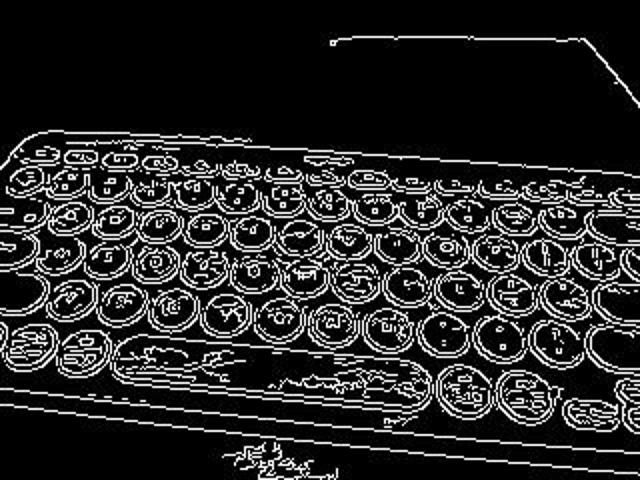


Traceback (most recent call last):
  File "<string>", line unknown, in <module>
Remote.KeyboardInterrupt


In [1]:
from maix import camera, display, image
while True:
    display.show(camera.capture().Canny())


## 特征检测模块


暂不做实现测试，但均已提交源码。

